In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Load and normalize CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [ ]:
# Note to myself: We are creating a transform pipeline
# 1. transforms.ToTensor() - converts image data into Pytorch tensors (normalize between 0 and 1)
# 2. transforms.Normalize() - normalize each channel (R,G,B) by subtracting the mean(0.5) and dividing std dev (0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4
# loads CIFAR-10 dataset - 60000 32*32 color images across 10 classes
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader and testloader, are the dataloader which creates batches of data and loads them efficiently during training/testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

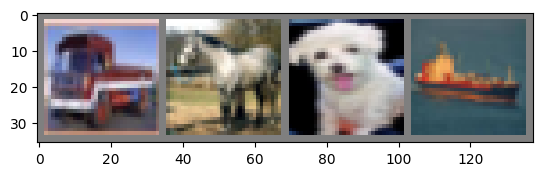

truck horse dog   ship 


In [6]:
# show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Convolution Neural Network

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
net = Net()

# 3. Define a Loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the network

In [10]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:   # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1: 5d} loss: { running_loss / 2000: .3f}]')
            running_loss = 0.0

print('Finished Training')

[1,  2000 loss:  2.230]
[1,  4000 loss:  1.893]
[1,  6000 loss:  1.683]
[1,  8000 loss:  1.594]
[1,  10000 loss:  1.525]
[1,  12000 loss:  1.475]
[2,  2000 loss:  1.413]
[2,  4000 loss:  1.387]
[2,  6000 loss:  1.348]
[2,  8000 loss:  1.324]
[2,  10000 loss:  1.302]
[2,  12000 loss:  1.303]
Finished Training


In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 5. Test the network on the test data

We have trained a convolution neural network consisting of 2 convolution layers and 3 fully connected layers over 2 passes (2 epochs) over the training dataset. Now we will predict the class label for images that CNN outputs and check it against the ground-truth. If prediction are correct, we add that image (sample) to the list of correct predictions.

In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

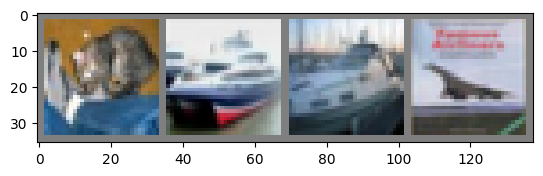

Ground Truth:  cat ship ship plane


In [14]:
# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]:.5s}' for j in range(4)))

In [15]:
# load back our saved model
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [16]:
outputs = net(images)

In [17]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ',' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [18]:
# how the network performs on the whole dataset
correct = 0
total = 0
# since we are not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 54 %


In [19]:
# which classes are performed well and which did not!
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class; {classname:5s} is {accuracy:.1f} %')

Accuracy for class; plane is 54.5 %
Accuracy for class; car   is 66.0 %
Accuracy for class; bird  is 24.4 %
Accuracy for class; cat   is 38.3 %
Accuracy for class; deer  is 26.5 %
Accuracy for class; dog   is 60.9 %
Accuracy for class; frog  is 64.3 %
Accuracy for class; horse is 61.7 %
Accuracy for class; ship  is 80.9 %
Accuracy for class; truck is 62.9 %


# 6. Training on GPU


In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0
